# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)
 * qualitative evaluations of word vectors: nearest neighbors, word analogies

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain
from argparse import Namespace

from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tensorboardX import SummaryWriter
from annoy import AnnoyIndex

In [2]:
DATA_PATH = Path('../data')
MODELS_PATH = Path('../models')

In [3]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        filtered_token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) 
                             in enumerate(filtered_token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
    
    def _create_sliding_window(self, window_size):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size):
#             center_word = islice(self.vectorized_tokens, i, i + 1)
#             left_context = islice(self.vectorized_tokens, i + 1, 
#                                   min(tokens_size, i + window_size + 1))
#             right_context = islice(self.vectorized_tokens, 
#                                    max(0, i - window_size), i)
#             yield from product(center_word, chain(left_context, right_context))
            center_word = self.vectorized_tokens[i:i+1]
#             context = []
#             context.extend(self.vectorized_tokens[max(0, i - window_size): i])
#             context.extend(self.vectorized_tokens[i + 1: min(tokens_size, i + window_size + 1)])
            left_context = self.vectorized_tokens[max(0, i - window_size): i]
            right_context = self.vectorized_tokens[i + 1: min(tokens_size, i + window_size + 1)]
            yield from product(center_word, chain(left_context, right_context))
        
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
        
    def generate_batches(self, window_size=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size)
        batch = list(zip(*islice(window, batch_size)))
        x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

        if drop_last:
            while batch and len(batch[0]) == batch_size:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])
        else:
            while batch:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = torch.tensor(batch[0]), torch.tensor(batch[1])

In [48]:
class NaiveWord2VecClassifier(nn.Module):
    def __init__(self, vocabulary_size, embedding_size):
        super().__init__()
        
        self.embedding = nn.Embedding(num_embeddings=vocabulary_size,
                                      embedding_dim=embedding_size,
                                      max_norm=1.0)
#                                       scale_grad_by_freq=True)
                                      
        self.fc1 = nn.Linear(in_features=embedding_size,
                             out_features=vocabulary_size,
                             bias=False)
        
    def forward(self, x_in):
        self.embedding.weight.data = F.normalize(self.embedding.weight.data, p=2, dim=1)
        x_embedded = self.embedding(x_in)
        y_out = self.fc1(x_embedded)
        
        return y_out

In [49]:
def set_seeds(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [55]:
args = Namespace(
    file_path = DATA_PATH/'text8',
    model_state_path = MODELS_PATH/'naive_word2vec_embeddings.pth',
    
    embedding_size = 100,
    
    seed = 42,
    cutoff = 10, # 10
    window_size = 1, # 1
    batch_size = 1024, #  1024
    learning_rate = 0.03, # 0.03
    iterations = 1000,
    save_iterations = 100,
    early_stopping_criteria = 1e8,
    factor=0.7, # 0.7
    patience=500, # 1000
    
    cuda=True
)

In [56]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': [], # args.learning_rate
            'batch_idx': 0,
            'loss': [],
            'model_file_name': args.model_state_path}

def update_train_state(args, model, train_state):
    if train_state['batch_idx'] == 0:
        train_state['stop_early'] = False
        torch.save(model.state_dict(), train_state['model_file_name'])
    else:
        loss = train_state['loss'][-1]

        if loss < train_state['early_stopping_best_val']:
            train_state['early_stopping_best_val'] = loss
            train_state['early_stopping_step'] = 0
            
            if train_state['batch_idx'] % args.save_iterations == 0:
                torch.save(model.state_dict(), train_state['model_file_name'])
        else:
            train_state['early_stopping_step'] += 1 
    
        train_state['stop_early'] = train_state['early_stopping_step'] >= args.early_stopping_criteria
    return train_state

In [57]:
if not torch.cuda.is_available():
    args.cuda=False
    
print(f'Using CUDA: {args.cuda}')
args.device = torch.device('cuda' if args.cuda else 'cpu')

Using CUDA: True


In [58]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=args.cutoff)

vocabulary_size = len(sg_batcher.vocab)
vocabulary_size

47134

In [59]:
set_seeds(args.seed)

classifier = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                                     embedding_size=args.embedding_size)
classifier = classifier.to(args.device)

loss_func = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(params=classifier.parameters(),
                      lr=args.learning_rate)

epoch_size = 2 * (args.window_size * len(sg_batcher.tokens) 
                  - np.math.factorial(args.window_size)) // args.batch_size

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min',
                                                 factor=args.factor,
                                                 patience=args.patience)

train_bar = tqdm_notebook(desc='Training',
                          position=1,
#                           total=args.iterations,
                          total=epoch_size)

batch_generator = sg_batcher.generate_batches(window_size=args.window_size, 
                                              batch_size=args.batch_size)

train_state = make_train_state(args)

writer = SummaryWriter(log_dir='logs/task_3', comment='embedding_training')

running_loss = 0.
classifier.train()

try:
    for batch_idx, (x_batch, labels_batch) in enumerate(batch_generator, 1):
        x_batch = x_batch.to(args.device)
        labels_batch = labels_batch.to(args.device)

        optimizer.zero_grad()

        y_pred = classifier(x_in=x_batch)

        loss = loss_func(y_pred, labels_batch)
        loss_value = loss.item()
        running_loss += (loss_value - running_loss) / (batch_idx)
        loss.backward()
        
        learning_rate = optimizer.param_groups[0]['lr']
        
        train_state['batch_idx'] = batch_idx
        train_state['loss'].append(running_loss)
        train_state['learning_rate'].append(learning_rate)
        writer.add_scalar('loss', scalar_value=loss, global_step=batch_idx)


        train_state = update_train_state(args=args,
                                         model=classifier,
                                         train_state=train_state)

        train_params = dict(loss=running_loss,
                            lr=learning_rate,
                            early_step=train_state['early_stopping_step'],
                            early_best=train_state['early_stopping_best_val'])
        train_bar.set_postfix(train_params)
        train_bar.update()
        
        optimizer.step()
        
        scheduler.step(train_state['loss'][-1])

        if train_state['stop_early'] or (batch_idx == epoch_size):
            break
except KeyboardInterrupt:
    print('Exit training')

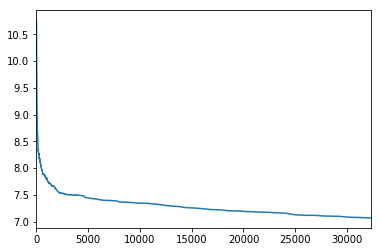

In [60]:
train_state_df = pd.DataFrame(train_state)
train_state_df['loss'].plot()
plt.show()

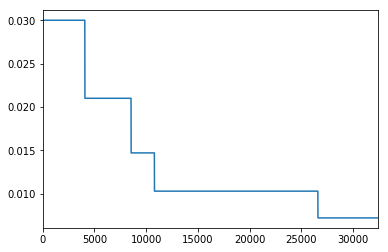

In [61]:
train_state_df['learning_rate'].plot()
plt.show()

In [62]:
metadata = list(sg_batcher.token_to_idx)
W = classifier.embedding.weight.cpu().detach().numpy()
W_prime = classifier.fc1.weight.cpu().detach().numpy()

W_avg = (W + W_prime) / 2

# writer.add_embedding(W, metadata=metadata, tag='W')
# writer.add_embedding(W_prime, metadata=metadata, tag='W_prime')
writer.add_embedding(W_avg, metadata=metadata, tag='W_avg')

In [63]:
W.min(), W.max()

(-0.69088125, 0.74361336)

In [64]:
W_norm = W / np.linalg.norm(W, axis=1, keepdims=True)
W_prime_norm = W_avg / np.linalg.norm(W_prime, axis=1, keepdims=True)
W_avg_norm = (W_norm + W_prime_norm) / 2
np.abs(W_norm).max(), np.abs(W_prime_norm).max(), np.abs(W_avg_norm).max()

(0.7419504, 0.30119526, 0.42798084)

In [65]:
from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

In [66]:
def plot_embeddings(embs_reduced, token_to_idx, tokens):
    token_embs = embs_reduced[[token_to_idx[token] for token in tokens]]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(token_embs[:, 0], token_embs[:, 1], alpha=0.2)
    
    for i, token in enumerate(tokens):
        ax.annotate(token, (token_embs[i, 0], token_embs[i, 1]))

In [67]:
%%time
pca = PCA(n_components=2)
embs_pca = pca.fit_transform(W_avg)

CPU times: user 352 ms, sys: 16 ms, total: 368 ms
Wall time: 94.4 ms


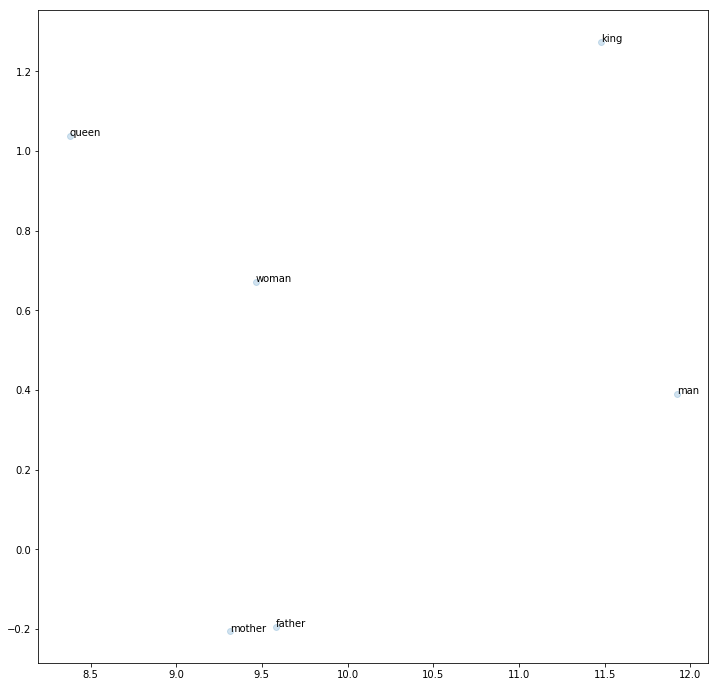

In [68]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(50)).keys())
plot_embeddings(embs_pca, sg_batcher.token_to_idx, tokens)

In [ ]:
%%time
tsne = TSNE(n_components=2, n_iter=1000, n_jobs=-1)
embs_tsne = tsne.fit_transform(W_avg)

In [ ]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_tsne, sg_batcher.token_to_idx, tokens)

In [ ]:
%%time
umap = UMAP(metric='cosine')
embs_umap = umap.fit_transform(W_avg)

In [ ]:
tokens = ['man', 'woman', 'king', 'queen', 'mother', 'father']
# tokens = list(dict(sg_batcher.token_counts.most_common(100)).keys())
plot_embeddings(embs_umap, sg_batcher.token_to_idx, tokens)

In [69]:
class EmbeddingsExplorer():
    def __init__(self, token_to_idx, vectors, metric='euclidean'):
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx 
                             in self.token_to_idx.items()}
        self.vectors = vectors
        self.metric = metric
        
        self.index = AnnoyIndex(vectors.shape[1], metric=metric)
        
        print('Building index is started')
        for i in self.token_to_idx.values():
            self.index.add_item(i, self.vectors[i])
        
        self.index.build(50)
        print('Building index is finished')
        
    def get_embedding(self, token):
        return self.vectors[self.token_to_idx[token]]
    
    def get_closest_to_vector(self, vector, n=1):
        nn_indices = self.index.get_nns_by_vector(vector, n)
        return [self.idx_to_token[neighbor] for neighbor in nn_indices]
    
    def compute_analogy(self, token1, token2, token3, n=10):
        vec1 = self.get_embedding(token1)
        vec2 = self.get_embedding(token2)
        vec3 = self.get_embedding(token3)
        vec4 = vec3 + vec2 - vec1
        
        tokens = set([token1, token2, token3])
        closest_tokens = self.get_closest_to_vector(vec4, n=n)
        closest_tokens = [token for token in closest_tokens
                          if token not in tokens]
        
        if len(closest_tokens) == 0:
            print('Could not find nearest neighbors for the computed vector')
            return
        
        for token4 in closest_tokens:
            print(f'{token1}:{token2} :: {token3}:{token4}')

In [84]:
embeddings = EmbeddingsExplorer(sg_batcher.token_to_idx, W_avg, metric='euclidean')
embeddings

Building index is started
Building index is finished


In [85]:
embeddings.compute_analogy('man', 'he', 'woman')

man:he :: woman:she
man:he :: woman:never
man:he :: woman:there
man:he :: woman:they
man:he :: woman:who
man:he :: woman:actually
man:he :: woman:since
man:he :: woman:then
man:he :: woman:when


In [86]:
embeddings.compute_analogy('fly', 'plane', 'sail')

fly:plane :: sail:tomb
fly:plane :: sail:paths
fly:plane :: sail:rotation
fly:plane :: sail:lens
fly:plane :: sail:departure
fly:plane :: sail:cave
fly:plane :: sail:photograph
fly:plane :: sail:thermal
fly:plane :: sail:parody


In [87]:
embeddings.compute_analogy('kitten', 'cat', 'puppy')

kitten:cat :: puppy:fish
kitten:cat :: puppy:colour
kitten:cat :: puppy:skin
kitten:cat :: puppy:milk
kitten:cat :: puppy:tree
kitten:cat :: puppy:similarly
kitten:cat :: puppy:yellow
kitten:cat :: puppy:fruit
kitten:cat :: puppy:hair
kitten:cat :: puppy:wild


In [88]:
embeddings.compute_analogy('blue', 'color', 'dog')

blue:color :: dog:copy
blue:color :: dog:message
blue:color :: dog:verse
blue:color :: dog:screen
blue:color :: dog:sample
blue:color :: dog:farm
blue:color :: dog:commands
blue:color :: dog:painting
blue:color :: dog:phrase
blue:color :: dog:display


In [89]:
embeddings.compute_analogy('leg', 'legs', 'hand')

leg:legs :: hand:humans
leg:legs :: hand:individuals
leg:legs :: hand:things
leg:legs :: hand:countries
leg:legs :: hand:subjects
leg:legs :: hand:animals
leg:legs :: hand:cases
leg:legs :: hand:bodies
leg:legs :: hand:cultures


In [90]:
embeddings.compute_analogy('toe', 'finger', 'foot')

toe:finger :: foot:feet
toe:finger :: foot:miles
toe:finger :: foot:hours
toe:finger :: foot:month
toe:finger :: foot:minutes
toe:finger :: foot:days
toe:finger :: foot:km
toe:finger :: foot:billion
toe:finger :: foot:image


In [91]:
embeddings.compute_analogy('talk', 'communicate', 'read')

talk:communicate :: read:marry
talk:communicate :: read:exposed
talk:communicate :: read:expand
talk:communicate :: read:extend
talk:communicate :: read:try
talk:communicate :: read:vowels
talk:communicate :: read:remove
talk:communicate :: read:survive
talk:communicate :: read:grow


In [92]:
embeddings.compute_analogy('man', 'king', 'woman')

man:king :: woman:prince
man:king :: woman:sir
man:king :: woman:son
man:king :: woman:governor
man:king :: woman:iii
man:king :: woman:pope
man:king :: woman:william
man:king :: woman:march
man:king :: woman:constitution


In [93]:
embeddings.compute_analogy('man', 'doctor', 'woman')

man:doctor :: woman:resident
man:doctor :: woman:parody
man:doctor :: woman:mandate
man:doctor :: woman:monk
man:doctor :: woman:performer
man:doctor :: woman:peasant
man:doctor :: woman:poll
man:doctor :: woman:warrior
man:doctor :: woman:sketch
man:doctor :: woman:possessed


In [94]:
embeddings.compute_analogy('fast', 'fastest', 'small')

fast:fastest :: small:growing
fast:fastest :: small:whole
fast:fastest :: small:larger
fast:fastest :: small:dominant
fast:fastest :: small:causing
fast:fastest :: small:overall
fast:fastest :: small:circle
fast:fastest :: small:vast
fast:fastest :: small:massive
fast:fastest :: small:huge


In [58]:
sg_batcher = SkipGramBatcher.from_file(args.file_path)
sg_batcher.prepare_data(cutoff=100000)

In [59]:
g = sg_batcher.generate_batches(window_size=5, 
                                batch_size=5)
x_batch, labels_batch = next(g)

x_batch, labels_batch

(tensor([0, 0, 0, 0, 0]), tensor([1, 2, 3, 2, 3]))

In [60]:
vocabulary_size = len(sg_batcher.vocab)
embedding_size = 50

vocabulary_size, embedding_size

(22, 50)

In [61]:
clf = NaiveWord2VecClassifier(vocabulary_size=vocabulary_size,
                              embedding_size=embedding_size)

In [102]:
y_pred = clf(x_batch)
# y_pred = F.softmax(y_pred, dim=1)
y_pred

tensor([[ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.0782,  0.1542, -0.5275, -0.5969, -0.2852,  0.9326, -0.0609,  1.0134,
          0.7858, -0.3970, -0.0972,  0.2352, -0.1621, -0.3524],
        [ 0.1679, -0.7678, -0.4254,  0.3084,  0.4510, -0.2278, -0.0301,  0.1163,
          0.078

In [79]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [103]:
y_pred[range(5), labels_batch]

tensor([-0.7678, -0.4254,  0.3084, -0.4254,  0.3084], grad_fn=<IndexBackward>)

In [80]:
-torch.log(y_pred[range(5), labels_batch])

tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NegBackward>)

In [95]:
y_true = torch.zeros((5, vocabulary_size), dtype=torch.long)
y_true[range(5), labels_batch] = 1

In [92]:
y_true.shape, y_pred.shape

(torch.Size([5, 22]), torch.Size([5, 22]))

In [104]:
loss = nn.CrossEntropyLoss(reduce=False)
loss(y_pred, labels_batch)

/opt/anaconda3/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


tensor([3.9903, 3.6480, 2.9141, 3.6480, 2.9141], grad_fn=<NllLossBackward>)

In [64]:
arr = torch.zeros((5, vocabulary_size))
arr[range(5), labels_batch] = 1
arr.sum(dim=1)

tensor([1., 1., 1., 1., 1.])

In [65]:
labels_batch

tensor([1, 2, 3, 2, 3])

In [70]:
loss = -np.log()

/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
